<a href="https://colab.research.google.com/github/AdaptiveMotorControlLab/LLaVAction/blob/main/example/llavaction_video_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLaVAction: Evaluating and Training Multi-Modal Large Language Models for Action Recognition

- This repository contains the implementation for our preprint on evaluating and training multi-modal large language models for action recognition.
- ⚠️ The demo *requires* an NVIDIA GPU, such as an A100.



## 🚨 Install LLaVAction:


In [1]:
!pip install --pre llavaction

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.1/256.1 kB 4.0 MB/s eta 0:00:00


## Install additional code dependencies

- Installing flash attention, which is important for fast inference.
- Install decord for efficient video reading.
- Installing LLaVAction source code.


In [ ]:
!pip install ninja
!pip install flash-attn --no-build-isolation
!pip install decord
!pip install gdown

Import inference and visualization functions from LLaVAction

In [3]:
import llavaction
from llavaction.action.selective_inference import SelectiveInferencer
from llavaction.action.make_visualizations import visualize_with_uid
import os

Please install pyav to use video processing functions.
OpenCLIP not installed


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Grab our demo video (from EPIC-KITCHENs-100):


In [ ]:
# demo data is hosted here:
!gdown --folder https://drive.google.com/drive/folders/1ql8MSWTK-2_uGH1EzPOrifauwUNg4E6i -O ./data

In [6]:
%cd data
%mkdir '/content/data/code'
%ls

/content/data
 checkpoint/   code/   EK100_512/  'No License'


## Setting Key parameters for LLaVAction:

- Specify where to load the EPIC-KITCHENS-100 video and grab the LLaVAction checkpoint from HuggingFace for the inference. If you followed our steps above, these paths do not need changed for Google Colaboratory.
- ⚠️ You can adjust `n_frames` to a higher number for better performance (which we empirically observed), but note this uses more compute.

In [7]:
data_root = '/content/data/EK100_512/EK100'
huggingface_checkpoint_path = 'MLAdaptiveIntelligence/LLaVAction-0.5B' # or MLAdaptiveIntelligence/LLaVAction-7B
n_frames = 16

inferencer = SelectiveInferencer(data_root,
                                     huggingface_checkpoint_path,
                                     include_time_instruction = False,
                                     n_frames = n_frames,
                                    use_flash_attention = True)

overwrite_config {}
Loaded LLaVA model: MLAdaptiveIntelligence/LLaVAction-0.5B


You are using a model of type qwen2 to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384


config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

Model Class: LlavaQwenForCausalLM


Define the 'caption' mode of the inference.

In [8]:
# Note, this does not need adjusted for the demo
def get_caption(inferencer,
                uid,
                checkpoint_folder):
    caption =  inferencer.inference('',
                                     uid,
                                     'caption')
    return caption

### You can modify the time range to query LLaVAction

- Our demo video is called `P01-P01_01` represents the video ID.
- `3.00` and `4.00` denotes the start and end in seconds, which you can modify (up to 15 seconds).

In [9]:
#You can change the start and stop time:
# for the demo video we provide, it is 15 seconds long:
start = '3.00'
stop = '4.00'

#video ID:
uid = f'P01-P01_01_{start}_{stop}'

#### Plot the video frames in the specified time range

P01/P01_01 3.0 4.0


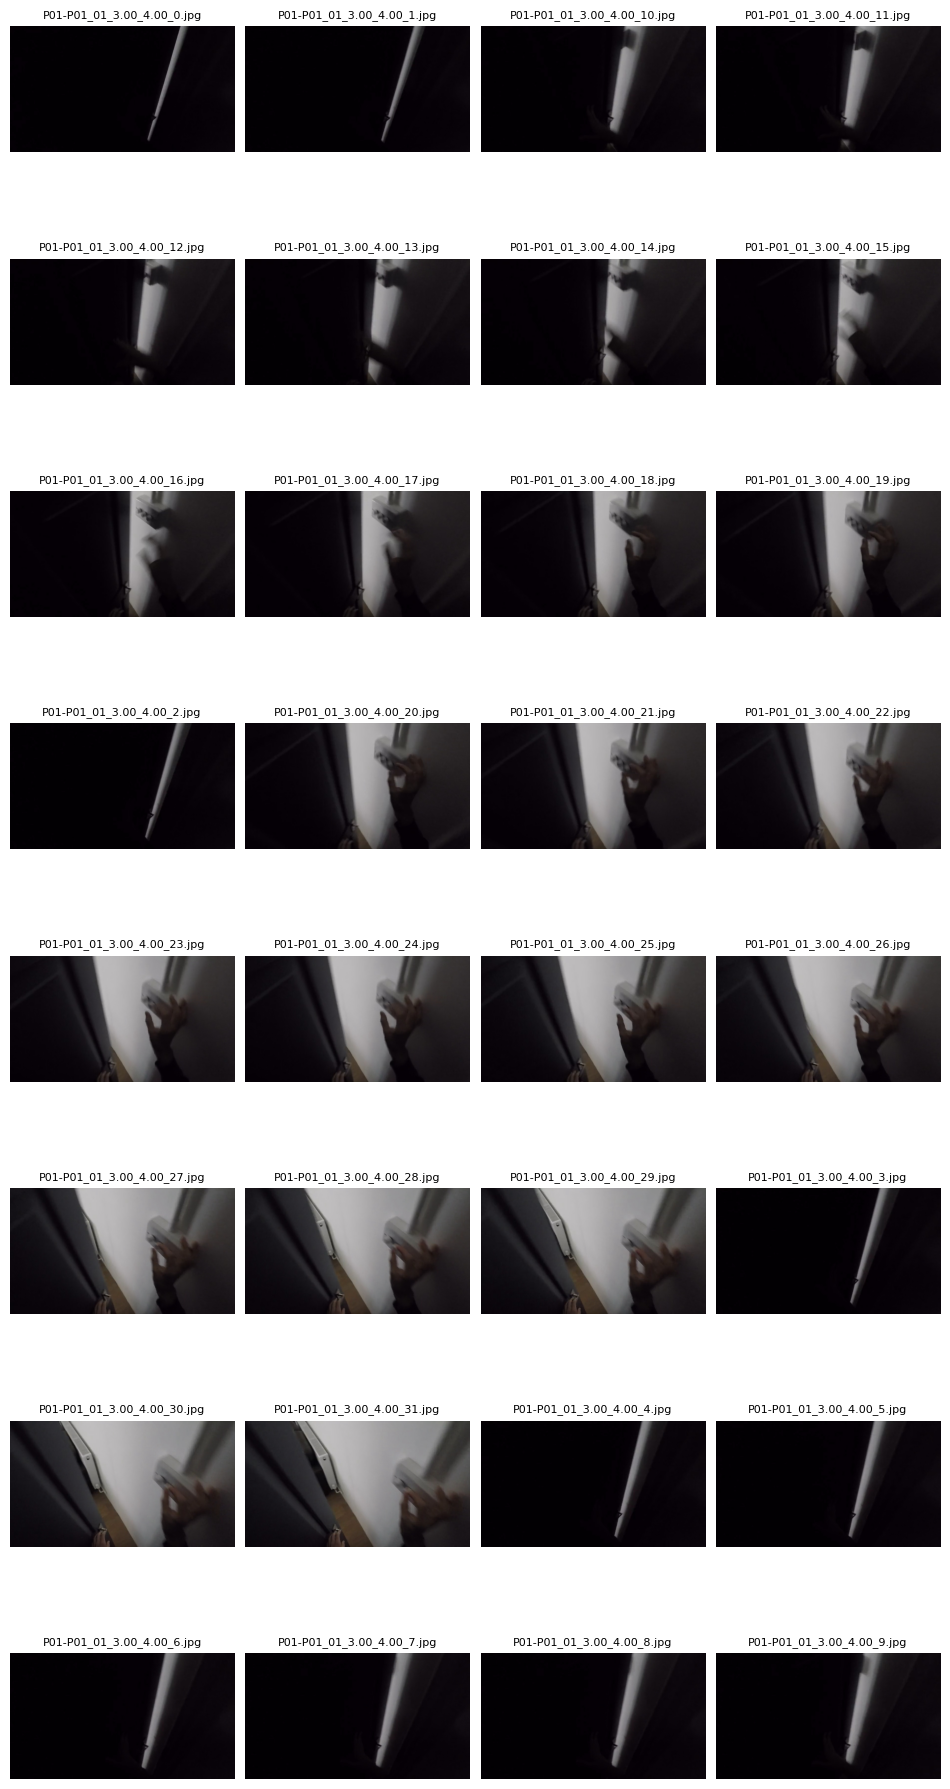

In [10]:
visualize_with_uid(data_root, uid, 'vis_folder')

import IPython.display as display
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

folder_path = f"vis_folder/{uid}"


# List all image files
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png", ".jpeg"))])

# Set grid dimensions
cols = 4  # Adjust this for the number of images per row
rows = (len(image_files) + cols - 1) // cols  # Calculate the required number of rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))  # Adjust figure size
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Reduce horizontal & vertical spacing

# Loop through images and display them in the grid
for ax, img_file in zip(axes.flatten(), image_files):
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
    ax.imshow(img)
    ax.set_title(img_file, fontsize=8)  # Display filename in smaller font
    ax.axis("off")  # Hide axis labels

# Hide unused subplots (if any)
for ax in axes.flatten()[len(image_files):]:
    ax.axis("off")

plt.show()





### Run the caption inference using LLaVAction
- this runs  on the video with the specified timestamps set above!

In [11]:
output_caption = get_caption(inferencer, uid, checkpoint_folder)
output_caption

debug P01-P01_01_3.00_4.00
P01/P01_01 3.0 4.0


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'In the video, I am reaching towards a door handle with my hand. As I grasp the handle, I pull it towards me, causing the door to open. The sequence of actions is consistent with opening a door, as I am interacting directly with the door handle and the door itself moves from a closed to an open position. The lighting in the scene further supports this action, as it becomes progressively brighter as the door opens wider.'

## Additional Tasks to consider
- here we use `spacy` do to some simple grouping of verbs/nouns.

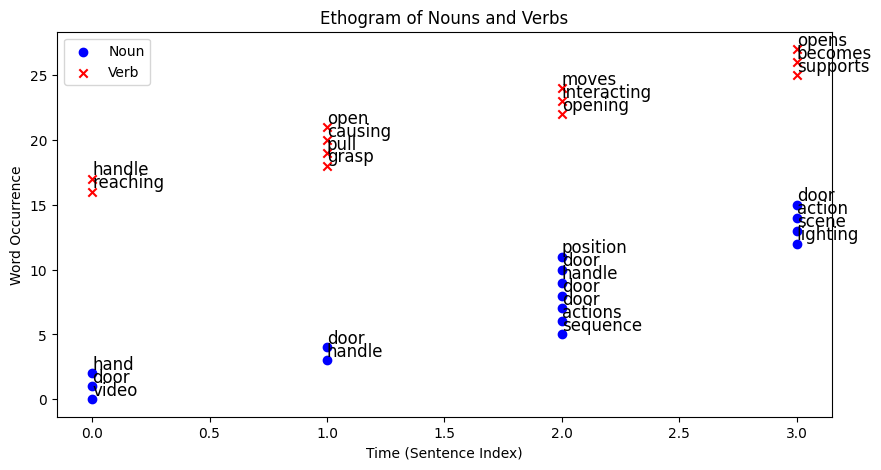

In [12]:
import spacy
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Input text
text = output_caption

# Process text
doc = nlp(text)

# Extract words with timestamps (sentence index)
nouns, verbs = [], []
for i, sent in enumerate(doc.sents):
    for token in sent:
        if token.pos_ in ["NOUN"]:
            nouns.append((i, token.text))
        elif token.pos_ in ["VERB"]:
            verbs.append((i, token.text))

# Plot
plt.figure(figsize=(10, 5))
for i, (t, word) in enumerate(nouns):
    plt.scatter(t, i, color='blue', label="Noun" if i == 0 else "", marker='o')
    plt.text(t, i, word, fontsize=12, verticalalignment='bottom')

for i, (t, word) in enumerate(verbs):
    plt.scatter(t, i + len(nouns), color='red', label="Verb" if i == 0 else "", marker='x')
    plt.text(t, i + len(nouns), word, fontsize=12, verticalalignment='bottom')

plt.xlabel("Time (Sentence Index)")
plt.ylabel("Word Occurrence")
plt.title("Ethogram of Nouns and Verbs")
plt.legend()
plt.show()


In [13]:
# Count nouns and verbs
num_nouns = len(nouns)
num_verbs = len(verbs)

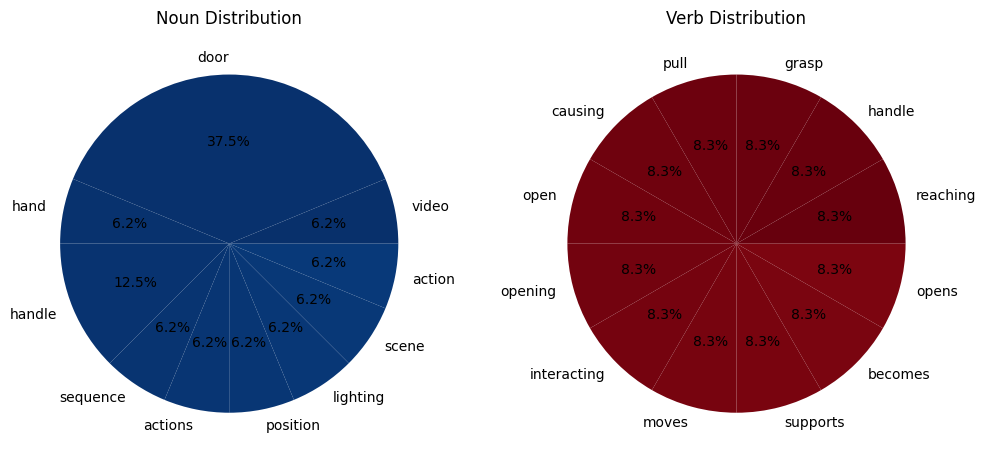

In [14]:
from collections import Counter

# Count occurrences of each noun and verb
noun_counts = Counter([word for _, word in nouns])
verb_counts = Counter([word for _, word in verbs])

# Plot pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Noun pie chart
axes[0].pie(noun_counts.values(), labels=noun_counts.keys(), autopct="%1.1f%%", colors=plt.cm.Blues_r(range(len(noun_counts))))
axes[0].set_title("Noun Distribution")

# Verb pie chart
axes[1].pie(verb_counts.values(), labels=verb_counts.keys(), autopct="%1.1f%%", colors=plt.cm.Reds_r(range(len(verb_counts))))
axes[1].set_title("Verb Distribution")

plt.show()
